<a href="https://colab.research.google.com/github/SergioManuelJob/RedNeuronalChess/blob/master/PrediccionAjedrezImagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sergio Manuel Suárez Suárez

# El dataset se encuentra en este link: https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset/data

## Importamos las librerías necesarias para el proyecto. La librería de torchvision es para cargar los datos.

In [171]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import warnings
warnings.filterwarnings('ignore')

import cv2
import os
import glob
import random

## Establecemos el directorio de trabajo, de donde cargaremos los datos. En este caso los cargamos del Drive.

In [172]:
data_dir = "/content/drive/MyDrive/Retos-De-Datos/ChessmanImages/Chessman-image-dataset/Chess"

## Configuramos el mapeo de las clases, poniendo aquellas que tenemos, en este caso, 6 clases. Son las 6 piezas de ajedrez diferentes.

## Además, establecemos el tamaños de las imágenes, el cual va a ser 64 x 64.

In [173]:
map_classes = {
    0: "Bishop", 1: "King", 2: "Knight", 3: "Pawn", 4: "Queen", 5: "Rook"
}

IMG_SIZE = 64

## Carga de imágenes de train, divididas mediante la label que se le asigna en "map_classes", esta etiqueta se asigna dependiendo de en qué carpeta esté la imagen, por lo cual la etiquetación se hace en la extracción de la imagen.

In [174]:
def load_train_set(dirname, map_characters, verbose=True):
    # Cargar imagenes de entrenamiento, etiquetarlas y agregarlas a los conjuntos de datos, desde un directorio
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg") or file.endswith("jpeg") or file.endswith("png") or file.endswith("JPG")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [175]:
X, y = None, None
X, y = load_train_set(data_dir, map_classes)
print("\nTrain set loaded")

Leyendo 86 imágenes encontradas de Bishop
Leyendo 75 imágenes encontradas de King
Leyendo 105 imágenes encontradas de Knight
Leyendo 106 imágenes encontradas de Pawn
Leyendo 77 imágenes encontradas de Queen
Leyendo 102 imágenes encontradas de Rook

Train set loaded


## Este método a diferencia del otro carga las imágenes de test, indicas con un número que se puede pasar por parámetro (por defecto elige 10 imágenes de cada clase) la cantidad de imágenes de cada clase que quieres para el conjunto de test, y devuelve los arrays con esas imágenes ya clasificadas.

## La selección de imágenes dentro de cada clase es aleatoria.

## También hay un control de error, para cuando se pida más imágenes de la que tiene alguna clase.

In [176]:
def load_test_set(dirname, map_characters, num_images=10, verbose=True):
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        # Comprobamos que no se pidan más imágenes de las que hay disponibles
        if num_images > len(files):
          print("Se ha puesto un número de imágenes mayor a la cantidad de fotos de alguna de las clases.")
          return None, None
        # Obtener índices aleatorios del conjunto "files", de una cantidad igual a la que se indique por parámetro (por defecto son 10)
        random_indices = random.sample(range(len(files)), min(num_images, len(files)))
        # Seleccionar archivos usando los índices aleatorios
        selected_files = [files[i] for i in random_indices]
        # Filtrar los archivos seleccionados por extensión
        images = [file for file in selected_files]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    print("\nEn total se han leído " + str(len(X_train)) + " imágenes")
    return np.array(X_train), np.array(y_train)

In [177]:
X_test, y_test = None, None
X_test, y_test = load_test_set(data_dir, map_classes)

Leyendo 10 imágenes encontradas de Bishop
Leyendo 10 imágenes encontradas de King
Leyendo 10 imágenes encontradas de Knight
Leyendo 10 imágenes encontradas de Pawn
Leyendo 10 imágenes encontradas de Queen
Leyendo 10 imágenes encontradas de Rook

En total se han leído 60 imágenes


## Barajamos aleatoriamente los datos, para que entrene de forma heterogenea y que no sea un entrenamiento tan homogeneo que pase clase por clase.

In [178]:
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Lo mismo para los datos de test.

In [179]:
perm = np.random.permutation(len(X_test))
X_test, y_test = X_test[perm], y_test[perm]

## Método que se utiliza para procesar la imagen y mostrarla, utilizando matplotlib.

In [180]:
def ver_imagen(x):
  plt.imshow(x)
  plt.show()

# Imagen antes de normalizar.

[[[ 98 161 194]
  [115 180 205]
  [104 170 198]
  ...
  [104 168 197]
  [120 179 203]
  [112 169 196]]

 [[ 39 127 173]
  [ 13  85 136]
  [ 13  32  53]
  ...
  [ 13  38  65]
  [ 17  73 114]
  [ 42 126 176]]

 [[ 33 130 180]
  [ 39  88 119]
  [ 64  27  32]
  ...
  [ 50  20  23]
  [ 31  76 100]
  [ 42 130 169]]

 ...

 [[ 24 130 181]
  [ 36  88 116]
  [ 57  28  33]
  ...
  [ 58  37  48]
  [ 40  69  93]
  [ 41 127 173]]

 [[ 55 130 178]
  [131 195 213]
  [159 209 214]
  ...
  [156 216 217]
  [131 200 213]
  [ 63 135 174]]

 [[ 14  96 161]
  [  7  92 157]
  [  9  94 157]
  ...
  [  9  92 157]
  [  9  90 157]
  [ 33  98 144]]]


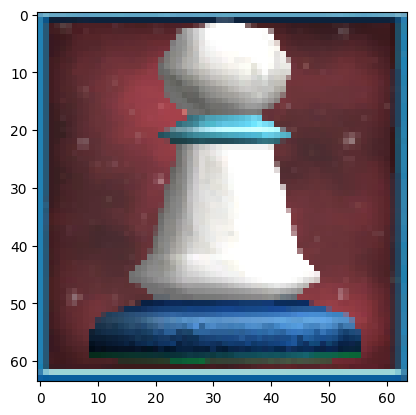

In [181]:
print(X[50])
ver_imagen(X[50])

# Normalizamos las imágenes, para que el modelo pueda entrenar mejor. Ver comparación, la imagen es igual, pero los datos de las imágenes están bien normalizados.

In [182]:
X = X / 255.0
X_test = X_test / 255.0

[[[0.38431373 0.63137255 0.76078431]
  [0.45098039 0.70588235 0.80392157]
  [0.40784314 0.66666667 0.77647059]
  ...
  [0.40784314 0.65882353 0.77254902]
  [0.47058824 0.70196078 0.79607843]
  [0.43921569 0.6627451  0.76862745]]

 [[0.15294118 0.49803922 0.67843137]
  [0.05098039 0.33333333 0.53333333]
  [0.05098039 0.1254902  0.20784314]
  ...
  [0.05098039 0.14901961 0.25490196]
  [0.06666667 0.28627451 0.44705882]
  [0.16470588 0.49411765 0.69019608]]

 [[0.12941176 0.50980392 0.70588235]
  [0.15294118 0.34509804 0.46666667]
  [0.25098039 0.10588235 0.1254902 ]
  ...
  [0.19607843 0.07843137 0.09019608]
  [0.12156863 0.29803922 0.39215686]
  [0.16470588 0.50980392 0.6627451 ]]

 ...

 [[0.09411765 0.50980392 0.70980392]
  [0.14117647 0.34509804 0.45490196]
  [0.22352941 0.10980392 0.12941176]
  ...
  [0.22745098 0.14509804 0.18823529]
  [0.15686275 0.27058824 0.36470588]
  [0.16078431 0.49803922 0.67843137]]

 [[0.21568627 0.50980392 0.69803922]
  [0.51372549 0.76470588 0.83529412]


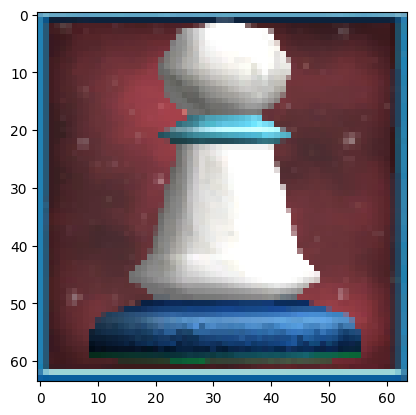

In [183]:
print(X[50])
ver_imagen(X[50])

# Entrenamiento

In [191]:
num_classes=len(map_classes)

## Convertimos la y en un one-hot encoder, creando una matriz que está llena de 0's, menos un único indice que tiene un 1, lo que indica la clase a la que pertenece.

In [185]:
y=keras.utils.to_categorical(y,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

## Aquí podemos ver lo que dije:

In [186]:
print(y_test)

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0.

In [187]:
print("Datos de training, X e Y respectivamente: " + str(X.shape), ", " + str(y.shape))
print("Datos de test, X e Y respectivamente: " + str(X_test.shape), ", " + str(y_test.shape))

Datos de training, X e Y respectivamente: (551, 64, 64, 3) , (551, 6)
Datos de test, X e Y respectivamente: (60, 64, 64, 3) , (60, 6)


## Selección de hiperparámetros y definición del tamaño del input.

In [281]:
epochs=16
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3)

## Modelo

Este modelo está ajustado para este problema, y empieza por una capa donde se indica el input_shape, que son las dimensiones de las imágenes que vamos a introducir en la red neuronal para que entrene, en este caso es 64x64.

Después creamos varias capas convolucionales, de no muchas neuronas ya que nuestro problema es más bien pequeño, con 6 clases a tener en cuenta, y un puñado de imágenes, y así no creamos ningún tipo de overfitting.

Las capas de MaxPooling es para sacar las características más importantes y así reducir la dimensión espacial, esto se repite varias veces para conservar así las mejores características siempre.

Le hacemos Flatten a las capas para crear un vector unidimensional.

Y al final hacemos un Dropout de neuronas, no muy grande (porque no son tantas neuronas), para evitar el overfitting, además de terminar con la última capa que da como respuesta 1 de las 6 clases.

In [297]:
model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=input_shape, activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(0.25),
  keras.layers.Dense(6, activation='softmax')
])

In [298]:
model.summary()
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_109 (MaxPool  (None, 31, 31, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_85 (Conv2D)          (None, 29, 29, 128)       36992     
                                                                 
 max_pooling2d_110 (MaxPool  (None, 14, 14, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_86 (Conv2D)          (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_111 (MaxPool  (None, 6, 6, 256)       

In [299]:
history=model.fit(X, y, epochs=epochs, validation_split = 0.2)

Epoch 1/16
14/14 [==============================] - 10s 658ms/step - loss: 1.8039 - accuracy: 0.1955 - val_loss: 1.8106 - val_accuracy: 0.1351
Epoch 2/16
14/14 [==============================] - 6s 409ms/step - loss: 1.7672 - accuracy: 0.1909 - val_loss: 1.8279 - val_accuracy: 0.1532
Epoch 3/16
14/14 [==============================] - 8s 556ms/step - loss: 1.7579 - accuracy: 0.2159 - val_loss: 1.8032 - val_accuracy: 0.2162
Epoch 4/16
14/14 [==============================] - 6s 410ms/step - loss: 1.7264 - accuracy: 0.2409 - val_loss: 1.8212 - val_accuracy: 0.2432
Epoch 5/16
14/14 [==============================] - 9s 662ms/step - loss: 1.6792 - accuracy: 0.3136 - val_loss: 1.7506 - val_accuracy: 0.2432
Epoch 6/16
14/14 [==============================] - 9s 671ms/step - loss: 1.6238 - accuracy: 0.3455 - val_loss: 1.6928 - val_accuracy: 0.2793
Epoch 7/16
14/14 [==============================] - 8s 504ms/step - loss: 1.5171 - accuracy: 0.4091 - val_loss: 1.6469 - val_accuracy: 0.2883
Epoch

Aquí seguimos un proceso muy parecido al del otro modelo, pero utilizando la tangente hiperbólica, y con el optimizador RMSprop.

In [300]:
model2 = keras.Sequential([
     keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last", input_shape=input_shape, activation='tanh'),
     keras.layers.MaxPooling2D(pool_size=(2, 2)),
     keras.layers.Conv2D(128, kernel_size=(3, 3), activation='tanh'),
     keras.layers.MaxPooling2D(pool_size=(2, 2)),
     keras.layers.Conv2D(256, kernel_size=(3, 3), activation='tanh'),
     keras.layers.MaxPooling2D(pool_size=(2, 2)),
     keras.layers.Flatten(),
     keras.layers.Dense(128, activation='tanh'),
     keras.layers.Dropout(0.25),
     keras.layers.Dense(6, activation='softmax')
])

# Resumen del modelo
model2.summary()

# Compilar el modelo
model2.compile(optimizer='RMSprop',
               loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_113 (MaxPool  (None, 31, 31, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_88 (Conv2D)          (None, 29, 29, 128)       36992     
                                                                 
 max_pooling2d_114 (MaxPool  (None, 14, 14, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_89 (Conv2D)          (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_115 (MaxPool  (None, 6, 6, 256)       

In [301]:
history2=model2.fit(X, y, epochs=epochs, validation_split=0.2)

Epoch 1/16
14/14 [==============================] - 9s 599ms/step - loss: 3.2983 - accuracy: 0.1909 - val_loss: 1.9540 - val_accuracy: 0.2162
Epoch 2/16
14/14 [==============================] - 6s 444ms/step - loss: 2.0390 - accuracy: 0.1795 - val_loss: 1.9157 - val_accuracy: 0.1441
Epoch 3/16
14/14 [==============================] - 8s 598ms/step - loss: 2.0328 - accuracy: 0.1727 - val_loss: 1.8372 - val_accuracy: 0.2252
Epoch 4/16
14/14 [==============================] - 6s 440ms/step - loss: 2.0045 - accuracy: 0.2295 - val_loss: 1.9827 - val_accuracy: 0.1532
Epoch 5/16
14/14 [==============================] - 8s 591ms/step - loss: 2.0464 - accuracy: 0.1727 - val_loss: 1.8261 - val_accuracy: 0.1982
Epoch 6/16
14/14 [==============================] - 6s 444ms/step - loss: 2.0333 - accuracy: 0.1682 - val_loss: 1.8503 - val_accuracy: 0.1351
Epoch 7/16
14/14 [==============================] - 8s 604ms/step - loss: 1.9860 - accuracy: 0.2091 - val_loss: 1.8351 - val_accuracy: 0.1802
Epoch 

## Los resultados, comparados a los de mi modelo original son peores, por lo que es mejor coger nuestro primer modelo.

In [271]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [272]:
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

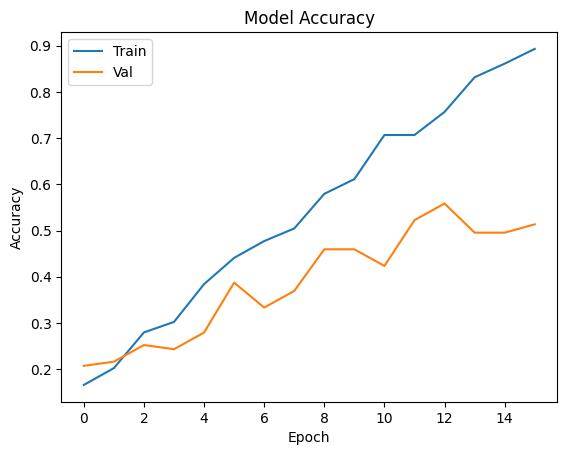

In [273]:
plot_acc(history)

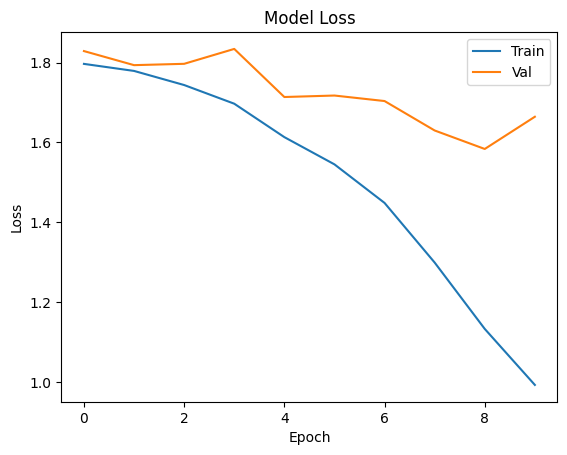

In [236]:
plot_loss(history)

## Probamos con los datos de test, haciendo una evaluación.

In [274]:
model.evaluate(X_test, y_test, batch_size=32, verbose=1)

2/2 [==============================] - 0s 187ms/step - loss: 0.6020 - accuracy: 0.8333


[0.6019948124885559, 0.8333333134651184]

Obtenemos una precisión del 83%, y un loss de 0.60.

## Ahora utilizamos el modelo para predecir.

Almacenamos las predicciones del test, para proceder a hacer una matriz de confusión y ver de forma visual qué tal predice.

In [276]:
prediccion=model.predict(X_test, batch_size=32, verbose=1)

2/2 [==============================] - 1s 176ms/step


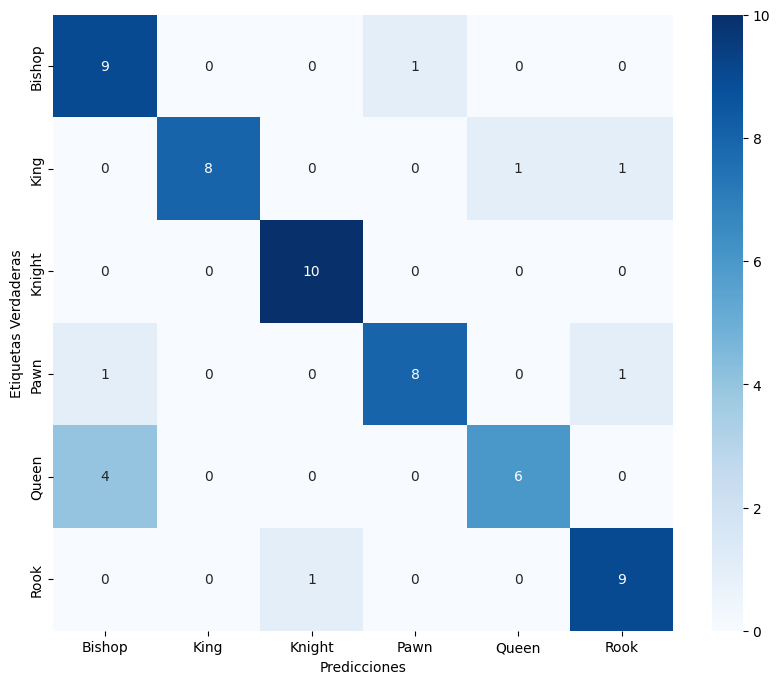

              precision    recall  f1-score   support

      Bishop       0.64      0.90      0.75        10
        King       1.00      0.80      0.89        10
      Knight       0.91      1.00      0.95        10
        Pawn       0.89      0.80      0.84        10
       Queen       0.86      0.60      0.71        10
        Rook       0.82      0.90      0.86        10

    accuracy                           0.83        60
   macro avg       0.85      0.83      0.83        60
weighted avg       0.85      0.83      0.83        60



In [280]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Convierte las predicciones y etiquetas verdaderas a clases
y_pred_classes = np.argmax(prediccion, axis=1)
y_true = np.argmax(y_test, axis=1)

# Se calcula la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Visualizamos la matriz de confusión
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=map_classes.values(), yticklabels=map_classes.values())
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()

# Hacemos el reporte
print(classification_report(y_true, y_pred_classes, target_names=map_classes.values()))

## Con esto, podemos ver que hay una clase que flojea ante todas las demás que es la del "bishop", o el alfil, mientras que todas las demás consiguen tener una mejor precisión. Esto podría ser debido a la falta de imágenes de calidad, o falta de imágenes hablando ya de volumen, pero en general, ha entrenado bien.